# Predicting Temperature using Graph Neural Networks


In this Notebook, we will predict temperature measurements across various locations, using altitude and temperature data of  few neighboring countries.
We will use a Graph Neural Network based model.


Problem formulation - Data structure and algorithm - 

1. Edges - Distance between locations (unlearned)
2. Nodes - 7 dimensional features. Altitude and month and pre-initialized and not learned. 3 more dimensions are learned, and temperature is partially learned (partial supervision - part of the nodes are the input, the rest are learned (initialized with 0). Another feature vector which indicates by one-hot which temperature measurement is blank.
3. Output - one label per node (temp is GT). Gradients are taken on all nodes.
4. Training - a training loop for each day ('dt' column). Learned features (edges and part of the node dimensions) are shared between samples.
5. Inference - No learning at all. Using the last learned features of the network. Check on test data, which has unseen dates. 


Below is a diagram which describes our flow - 
Given data with temperature samples in various locations, we want to learn the temperature of neighboring areas. 
We create a graph from the samples, initialize the nodes and edges as described previously.
We then learn the missing temperatures using our model.

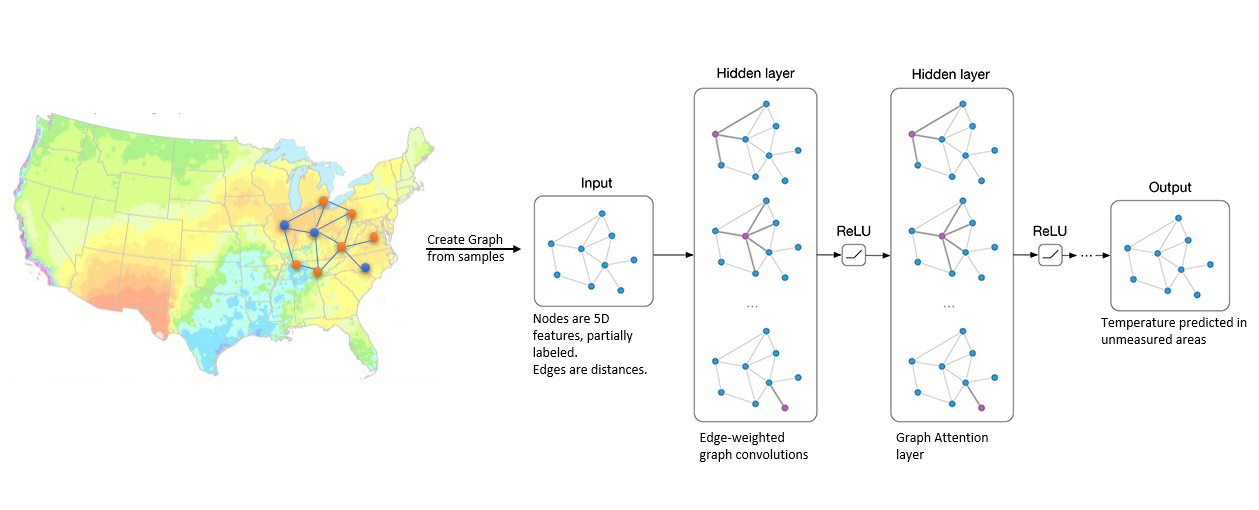

#### Module Installation

In [23]:
!pip install networkx 
!conda install -c dglteam dgl-cuda10.1 -y

# used for distance calculation between cities
!pip install geopy  

# used for visualizing the graphs
!pip install graphviz
!pip install cgraph
!conda install python-graphviz -y
!pip install pygraphviz


#### Module Import

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
import geopy
import geopy.distance
import requests
import urllib
import os.path as osp
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, CyclicLR
import matplotlib as mpl


import itertools
from dgl.nn.pytorch import GraphConv, SAGEConv

from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt


import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

import copy
from datetime import datetime



Using backend: pytorch


#### Data Proccessing
We will use data from the dataset "Climate Change: Earth Surface Temperature Data" which is available on Kaggle - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

This dataset has many temperature samples, we will only use samples from the USA in a single day.
To enrich the data, we will obtain the altitude of each city.


In [3]:
# get data from here - 
# read data, take only data for USA at the most recent date (day)
df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
usa_df  = df[df['Country']=="United States"]
usa_df['coords'] = usa_df["Latitude"] + usa_df["Longitude"]
usa_df['coords_date'] = usa_df['coords'] + usa_df['dt']
usa_df = usa_df.drop_duplicates(subset="coords_date")  # remove duplicates

# Create time column
usa_df['date'] = usa_df['dt'].apply(lambda x : datetime.strptime(x, "%Y-%m-%d"))

# Filter any date before 2005
usa_df = usa_df.loc[usa_df['dt'] >= datetime(day=1, month=1, year=2005)]

latest_df = usa_df[usa_df['dt']=="2013-05-01"]
# latest_df = latest_df.fillna(0)
# latest_df = latest_df.drop_duplicates(subset="coords")  # remove duplicates

city_list = latest_df["coords"].unique()
n_city_list = len(city_list)

# Remove cities without recent measurements
usa_df = usa_df.loc[usa_df["coords"].isin(city_list)]

# df = df.head(10)  # used for testing...
# df.shape

In [4]:
# Remove days with partial measurements
remove_idx_list = []
for date in usa_df['dt'].unique():
    date_city_series = usa_df.loc[usa_df['dt']==date, 'coords']
    if date_city_series.shape[0] < n_city_list:
        remove_idx_list += list(date_city_series.index)
        
# Remove cities with more than one measurments 
usa_df.drop(index=remove_idx_list, inplace=True)

In [5]:
print("Number of cities in the Dataset = {}".format(n_city_list))
print("Number of days in the Dataset = {}. From {} to {}.".format(usa_df['dt'].nunique(), min(usa_df['dt']), max(usa_df['dt'])))

Number of cities in the Dataset = 97
Number of days in the Dataset = 1977. From 1849-01-01 to 2013-09-01.


In [6]:
df = usa_df
df = df.fillna(0)

In [7]:
import time
# Add elevation for each lat-long - takes ~1sec per coordinate
# USGS Elevation Point Query Service - needs a different format of points, so casted by geopy
url = r'https://nationalmap.gov/epqs/pqs.php?'



def elevation_function(df):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = {}
    for lat, lon, coord in zip(df["Latitude"], df["Longitude"], df["coords"]):
        time.sleep(0.3 )  # added so not to receive time-outs from the site
        pos = geopy.Point.from_string(lat + " " + lon)
        # query params
        params = {
            'output': 'json',
            'x': pos.longitude, 
            'y': pos.latitude, 
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        # elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        elevations[coord] = result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']
    return elevations

e = elevation_function(latest_df) # run only on one day of cities

df['elev_meters'] = df['coords'].apply(lambda x: e[x])
latest_df['elev_meters'] = latest_df['coords'].apply(lambda x: e[x])
df = df[df['elev_meters'] != '-1000000']  # remove nodes with faulty values
latest_df = latest_df[latest_df['elev_meters'] != '-1000000']  # remove nodes with faulty values

df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,coords,coords_date,elev_meters
47903,1849-01-01,5.131,3.482,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-01-01,631.85
47904,1849-02-01,6.776,1.929,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-02-01,631.85
47905,1849-03-01,13.135,1.859,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-03-01,631.85
47906,1849-04-01,17.381,2.626,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-04-01,631.85
47907,1849-05-01,20.393,1.379,Abilene,United States,32.95N,100.53W,32.95N100.53W,32.95N100.53W1849-05-01,631.85


In [125]:
# In order to run the Notebook faster, the dataframe will be stored in memory
df.to_pickle("data.pkl")


In [2]:
# and here, it can be loaded again...
df = pd.read_pickle("data.pkl")


In [3]:
%%time 

# List of cities 
city_list = df["City"].unique()

# Dict with distances between cities 
city_dict = dict()  # key (coords, coords), value - distance

city_coords = df['coords'].unique()
latest_df = df[df['dt']=="2013-05-01"]

for city_a  in city_coords:
    for city_b  in city_coords:
        city_a_df = latest_df.loc[latest_df['coords'] == city_a]
        city_b_df = latest_df.loc[latest_df['coords'] == city_b]
        pos1 = geopy.Point.from_string(city_a_df["Latitude"].values[0] + " " + city_a_df["Longitude"].values[0])
        pos2 = geopy.Point.from_string(city_b_df["Latitude"].values[0] + " " + city_b_df["Longitude"].values[0])
        dist = float(geopy.distance.distance(pos1, pos2).meters)  # geopy distance
        if dist == 0:  # no self edges
            continue
        dist = np.asarray([dist])
        city_dict[(city_a, city_b)] = dist



CPU times: user 9.8 s, sys: 12.1 ms, total: 9.81 s
Wall time: 9.8 s


Below, a graph structure is built from the data.
Each city (temperature sample) will be a node in the graph. Each city has temperature and altitude features.

For each city, we calculate distances to all other cities, and take the 10 nearest cities, and link them via an edge. Each edge is weighed by the distance. There are no self loops.

In [4]:

num_neighbors = 10


# Create a function that creates a graph per date
def make_graph_per_day(df, date, create_nx=False):
    df = df[df['dt']==date]

    # create the graph - both nx and dgl (converting from nx to dgl failed )
    if create_nx:
        graph= networkx.Graph()
    g = dgl.DGLGraph()
    
    for idx, coord in enumerate(city_coords):
        city_df = df.loc[df['coords'] == coord]
        avg_temp = float(city_df["AverageTemperature"].values[0])
        elevation = float(city_df["elev_meters"].values[0])
        city = city_df["City"].values[0]

        temp = np.asarray([avg_temp], dtype=np.float32)
        height = np.asarray([elevation], dtype=np.float32)

        if create_nx:
            graph.add_node(idx, city_name=city, temp=temp, height=height)

        g.add_nodes(1, {'temp': torch.from_numpy(temp), 'height':torch.from_numpy(height)})

    for idx_a, city_name_a in enumerate(city_coords):
        v_e_dict = {}
        dists_sorted = []
        city_a_df = df.loc[df['coords'] == city_name_a]
        for idx_b, city_name_b in enumerate(city_coords):
            city_b_df = df.loc[df['coords'] == city_name_b]
            city_a = city_a_df["coords"].values[0]
            city_b = city_b_df["coords"].values[0]
            if city_a == city_b:
                continue

            distance = city_dict[(city_a, city_b)]
            distance = np.asarray([distance])
            v_e_dict[idx_b] = distance  # for this city1, for each city2, save dist in dict
            dists_sorted.append(distance)

        # go over distances, add only X closest neighbors
        dists_sorted.sort()
        dists_sorted = dists_sorted[0:num_neighbors]

        for ii, dist in enumerate(v_e_dict.items()):
            city, distance_ = dist
            if distance_ > 0 and distance_ in dists_sorted:
                ### graph.add_edge(row1[1]["City"], row2[1]["City"], distance=distance)
                if create_nx:
                    graph.add_edge(idx_a, city, distance=distance_)
                g.add_edge(idx_a, city, {'distance':torch.from_numpy(distance_)})

    if create_nx:
        return graph, g
    else:
        return g

dates  = df['dt'].unique()
test_graphs = {}
train_graphs = {}

for idx, date in enumerate(dates):
    dt = datetime.strptime(date, "%Y-%m-%d")
    g = copy.deepcopy(make_graph_per_day(df, date))
    if dt.year == 2013:
        test_graphs[date] = g
    else:
        train_graphs[date] = g



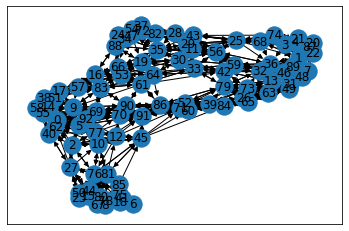

In [5]:
# networkx.draw(graph, with_labels=True, font_weight='bold')

nx.draw_networkx(g.to_networkx())
plt.show()


In [6]:
# find a dominating set of vertices which can be used for learning the rest of the vertices

from networkx.algorithms.dominating import dominating_set
g_nx = g.to_networkx()

# # to create our dataset, mimic missing measurements by finding some independent set of graph
# we will attempt to learn it!
remove = dominating_set(g_nx)

keep = np.asarray(list(set(np.arange(len(g_nx))) - remove), dtype=np.int64)
remove = np.asarray(list(remove), dtype=np.int64)
labeled_cities = city_coords[remove]
unlabeled_cities = city_coords[keep]
print(f'There are {len(remove)} nodes as input, and {len(keep)} nodes are learned from')
print("Cities with known temprature (both in training and inference) are: {}".format(city_list[remove]))

There are 14 nodes as input, and 79 nodes are learned from
Cities with known temprature (both in training and inference) are: ['Abilene' 'Akron' 'Albuquerque' 'Allentown' 'Anchorage' 'El Paso'
 'Atlanta' 'Austin' 'Gainesville' 'Beaumont' 'Tallahassee' 'Cape Coral'
 'Cary' 'Chandler']


#### The Model used - Weighed Graph Convolutions
We will use a 3 layer Graph Convolution Network.
Instead of summing the neighbors features to each node, the aggregation function will take a weighted mean of each neighbors' features. 
A softmax function will be used to create probablity-like weights from the distance of each node. We will take a complement of this (1 minus the result) in order for closer nodes to affect the features more than the further ones.


In [7]:
class WeighedGraphConv(nn.Module):

    def __init__(self,
                 in_feats,
                 out_feats,
                 num_neighbors, 
                 weight=True,
                 bias=True):
        super(WeighedGraphConv, self).__init__()

        self._in_feats = in_feats
        self._out_feats = out_feats
        self.num_neighbors = num_neighbors

        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        torch.nn.init.xavier_uniform_(self.weight)

        self.bias = nn.Parameter(torch.Tensor(out_feats))       
        self.res_fc = nn.Linear(in_feats, out_feats, bias=False)


    # graph is the complete input graph (data), feat are the learned nodes (shared between all graphs)
    # edges are the learned edges (shared between all graphs)
    def forward(self, graph, feat, edges):
        
        feat, feat_dst = dgl.utils.expand_as_pair(feat)
        
        graph = graph.local_var()
        # normalize input features
        degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
        norm = torch.pow(degs, -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)
        feat = feat * norm

        weight = self.weight

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, weight)
        graph.srcdata['h'] = feat

        graph.edata['ee'] = edges

        # AK - multiply nodes by edge weights, and sum
        graph.update_all(fn.u_mul_e('h', 'ee', 'm'), fn.sum('m', 'h'))
        rst = graph.dstdata['h']

        if self.bias is not None:
            rst = rst + self.bias
            
        # residual connection
#         rst = rst + self.res_fc(feat_dst)

        return rst



LeakyReLu functions are used in between the layers. 
The nodes have 5-dimension features which are initialized with a normal distribution.

In [8]:
from dgl.nn import GATConv

class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_neighbors):
        super(Net, self).__init__()
        self.conv1 = WeighedGraphConv(in_feats, hidden_size, num_neighbors)
        self.conv2 = GATConv(hidden_size , 1, 1, residual=True, attn_drop=0.1, feat_drop=0.1)

    def forward(self, g, feats_, edges_):
        h = self.conv1(g, feats_, edges_)
        h = torch.nn.functional.leaky_relu(h, 0.1)
        h = self.conv2(g, h) #, edges_)
        return h

    

net = Net(7, 5, num_neighbors)  # num_of_classes = temp
print(net)

embed = nn.Embedding(len(g), 3)  # |g| nodes with embedding dim equal to 2
torch.nn.init.normal_(embed.weight)
edges_embed = nn.Embedding(g.edata['distance'].shape[0], 1)  # 


Net(
  (conv1): WeighedGraphConv(
    (res_fc): Linear(in_features=7, out_features=5, bias=False)
  )
  (conv2): GATConv(
    (fc): Linear(in_features=5, out_features=1, bias=False)
    (feat_drop): Dropout(p=0.1, inplace=False)
    (attn_drop): Dropout(p=0.1, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (res_fc): Linear(in_features=5, out_features=1, bias=False)
  )
)


#### Training and Validation
We will only use the dominating set of nodes for supervision. The rest of the node features will be learned.
We train for 30 epochs.
Adam optimizer and MSE loss were used.


In [76]:
%%time

labeled_nodes = torch.from_numpy(remove) # only a small part of the nodes are used for supervision
unlabeled_nodes = torch.from_numpy(keep)

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters(), edges_embed.parameters()), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.8)


num_epochs = 60
losses = []
accuracies = []

gnn_pred_train_y = np.zeros((len(train_graphs), unlabeled_cities.shape[0])) # test_days x unlabaled_cities


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = net.to(device)
embed = embed.to(device)
edges_embed = edges_embed.to(device)

for epoch in range(num_epochs):

    running_loss = 0.0
    running_temp_err = 0.0

    iteration = 0
    for date, g in train_graphs.items():
        iteration += 1

        # build features according to current graph
        # the node features are partially initialized with input data, and partially learned (shared between graphs)
        temp_ = g.ndata['temp'].to(device)
        height_ = g.ndata['height'].to(device)

        # month feature
        dt = datetime.strptime(date, "%Y-%m-%d")
        month = torch.tensor(float(dt.month))
        month = month.repeat(g.ndata['temp'].shape).to(device)

        # "corrupt" temp feature - gives the NN an indication which node is corrupt
        keep_vec = torch.ones_like(temp_).to(device)
        keep_vec[unlabeled_nodes] = 0

        labels = torch.stack([temp_, height_, month, keep_vec], dim=1).detach()  # no grads here...
        labels[unlabeled_nodes, 0] = 0  # delete temp data 
        features = torch.cat([embed.weight, labels.clone().detach()], 1)
        
        gt = torch.tensor(g.ndata['temp'])

        # prepare distances as probabilities
        edges_distance = g.edata['distance'].unsqueeze(-1).detach()  # no grads here...
        
        edge_norm = torch.norm(edges_distance.view(num_neighbors, -1), dim=0, keepdim=True)
        edges_distance = edges_distance.view(num_neighbors, -1) /  edge_norm
        edges_distance = edges_distance.flatten()
        edges_dist_vec = torch.tensor(edges_distance, dtype=torch.float).detach().to(device)

        edges =  edges_dist_vec# * edges_embed.weight.squeeze()

        gt, features, edges, labels = gt.to(device), features.to(device), edges.to(device), labels.to(device)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # Set model to training mode
            else:
                net.eval()   # Set model to evaluate mode

            # print(features.shape)
            logits = net(g, features, edges).squeeze()
            logits = logits.to(device)
            
            if epoch + 1 == num_epochs:
                for unlabled_idx, unlabled_city in enumerate(unlabeled_cities):
                    gnn_pred_train_y[iteration-1, unlabled_idx] = logits[np.where(unlabled_city == city_coords)[0][0]].cpu() ## get GNN index from name


            if phase == 'train':
                # learn from all availble data
                loss = F.mse_loss(logits, gt)
            
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()

            else:  # eval phase (on training data, don't take grads)
                with torch.set_grad_enabled(False):
                    # validation accuracy - 
                    mean_err = torch.mean(torch.abs(logits[unlabeled_nodes] - gt[unlabeled_nodes] ))
                    running_temp_err += mean_err.data


    running_loss /= iteration
    if epoch % 5 == 0:
        print('Epoch %d | Loss: %.4f' % (epoch, running_loss))
    losses.append(running_loss)

    running_temp_err /= iteration
    if epoch % 5 == 0:
        print('Epoch %d | Mean Temp Error: %.4f' % (epoch, running_temp_err))
    accuracies.append(running_temp_err)

    # Decay Learning Rate
    scheduler.step()



/home/toky/anaconda3/envs/asaf_37/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/toky/anaconda3/envs/asaf_37/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0 | Loss: 17.5620
Epoch 0 | Mean Temp Error: 2.5600
Epoch 5 | Loss: 13.4924
Epoch 5 | Mean Temp Error: 2.1167
Epoch 10 | Loss: 10.5355
Epoch 10 | Mean Temp Error: 1.7849
Epoch 15 | Loss: 12.5923
Epoch 15 | Mean Temp Error: 2.0311
Epoch 20 | Loss: 10.3055
Epoch 20 | Mean Temp Error: 1.7079
Epoch 25 | Loss: 11.5164
Epoch 25 | Mean Temp Error: 1.8709
Epoch 30 | Loss: 12.4925
Epoch 30 | Mean Temp Error: 1.9282
Epoch 35 | Loss: 10.9399
Epoch 35 | Mean Temp Error: 1.8225
Epoch 40 | Loss: 12.2503
Epoch 40 | Mean Temp Error: 1.9712
Epoch 45 | Loss: 11.3467
Epoch 45 | Mean Temp Error: 1.8607
Epoch 50 | Loss: 9.7393
Epoch 50 | Mean Temp Error: 1.5294
Epoch 55 | Loss: 8.7636
Epoch 55 | Mean Temp Error: 1.4706
CPU times: user 1min 12s, sys: 273 ms, total: 1min 12s
Wall time: 1min 12s


### Test loop

In [77]:
# test loop
gnn_pred_y = np.zeros((len(test_graphs), unlabeled_cities.shape[0])) # test_days x unlabaled_cities

test_accuracies = []

running_temp_err_val = 0.0

iteration = 0
for date, g in test_graphs.items():
    iteration += 1
    
    # build features according to current graph
    # the node features are partially initialized with input data, and partially learned (shared between graphs)
    temp_ = g.ndata['temp'].to(device)
    height_ = g.ndata['height'].to(device)

    # month feature
    dt = datetime.strptime(date, "%Y-%m-%d")
    month = torch.tensor(float(dt.month))
    month = month.repeat(g.ndata['temp'].shape).to(device)

    # "corrupt" temp feature - gives the NN an indication which node is corrupt
    keep_vec = torch.ones_like(temp_)
    keep_vec[torch.from_numpy(keep)] = 0
    keep_vec = keep_vec.to(device)


    labels = torch.stack([temp_, height_, month, keep_vec], dim=1).detach()  # no grads here...
    labels[torch.from_numpy(keep), 0] = 0  # delete temp data 

    embed, labels = embed.to(device), labels.to(device)
    features = torch.cat([embed.weight, labels], 1)
    # features = labels

    
    gt = torch.tensor(g.ndata['temp'])

    # prepare distances as probabilities
    edge_norm = torch.norm(edges_distance.view(num_neighbors, -1), dim=0, keepdim=True)
    edges_distance = edges_distance.view(num_neighbors, -1) /  edge_norm
    edges_distance = edges_distance.flatten()
    edges_dist_vec = torch.tensor(edges_distance, dtype=torch.float).detach().to(device)

    edges =  edges_dist_vec 

    net.eval()   # Set model to evaluate mode

    gt, features, edges = gt.to(device), features.to(device), edges.to(device)

    logits = net(g, features, edges).squeeze().to(device)
    for unlabled_idx, unlabled_city in enumerate(unlabeled_cities):
        gnn_pred_y[iteration-1, unlabled_idx] = logits[np.where(unlabled_city == city_coords)[0][0]].cpu() ## get GNN index from name
        
    with torch.set_grad_enabled(False):
        # validation accuracy - 
        mean_err = torch.mean(torch.abs(logits[unlabeled_nodes] - gt[unlabeled_nodes] ))
        running_temp_err_val += mean_err.data


running_temp_err_val /= iteration
print('Mean Temp Error on Validation set: %.4f' % (running_temp_err_val));

Mean Temp Error on Validation set: 1.4419


/home/toky/anaconda3/envs/asaf_37/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/toky/anaconda3/envs/asaf_37/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [11]:
### train loop (for testing)

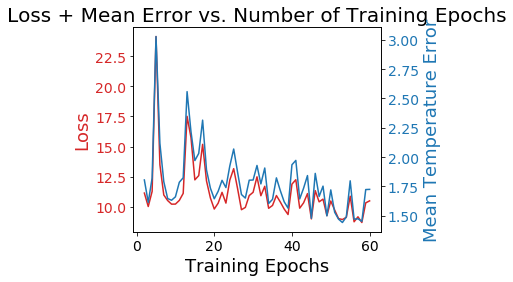

In [78]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(2,num_epochs+1),losses[1:],label="Loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.title("Loss + Mean Error vs. Number of Training Epochs")
plt.xlabel("Training Epochs")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Mean Temperature Error", color=color)  # we already handled the x-label with ax1
ax2.plot(range(2,num_epochs+1),accuracies[1:],label="Mean Temp Error", color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Baselines

## Data for baselines

In [40]:

def create_dataset(df):
    day_num = df['dt'].nunique()
    labeled_n = len(labeled_cities)
    unlabeled_n = len(unlabeled_cities)
    
    X = np.zeros((day_num, unlabeled_n, 2 * labeled_n + 2)) #2 features are altitude+month, the others are temp and altitude for each city 
    y =  np.zeros((day_num, unlabeled_n, 1)) # temp for each city
    for date_idx, date in enumerate(df['dt'].unique()):
        day_df = df.loc[df['dt'] == date]

        for city_idx, city in enumerate(unlabeled_cities):
            city_df = day_df.loc[df['coords'] == city]
            y[date_idx, city_idx, 0] = float(day_df.loc[df['coords'] == city, 'AverageTemperature'].values[0])      
            X[date_idx, city_idx, 0] = float(datetime.strptime(date, "%Y-%m-%d").month)
            X[date_idx, city_idx, 1] = float(city_df['elev_meters'].values[0])
            
            for city_idx_, city_ in enumerate(labeled_cities):
                city_df_ = day_df.loc[df['coords'] == city_]
                X[date_idx, city_idx, 2*city_idx_+2] = float(city_df_['AverageTemperature'].values[0])
                X[date_idx, city_idx, 2*city_idx_+3] = float(city_df_['elev_meters'].values[0])

    
    return X.reshape(day_num * unlabeled_n, -1), y.reshape(day_num * unlabeled_n ,-1)

train_df = df.loc[df['date'] < datetime(day=1, month=1, year=2013)]
test_df = df.loc[df['date'] >= datetime(day=1, month=1, year=2013)]
                 
train_X, train_y = create_dataset(train_df)
test_X, test_y = create_dataset(test_df)




## Baseline - Monthly Average Temp

In [41]:
# Average Temp
month_avg = np.zeros((12, test_y.shape[1]))
avg_pred_train_y = np.zeros_like(train_y)
avg_pred_y = np.zeros_like(test_y)

for month in range(12):
    month_samples = (train_X[:, 0] == month + 1)
    month_avg[month] = train_y[month_samples].mean(axis=0)
    avg_pred_train_y[month_samples] = np.repeat(month_avg[month], month_samples.sum()).reshape(-1, month_samples.sum()).T
    test_month_samples = (test_X[:, 0] == month + 1)
    if test_month_samples.any():
        avg_pred_y[test_month_samples] = np.repeat(month_avg[month], test_month_samples.sum()).reshape(-1, test_month_samples.sum()).T
    
avg_train_mean_err = np.abs(train_y - avg_pred_train_y).mean()
avg_test_mean_err = np.abs(test_y - avg_pred_y).mean()
print('Mean Temp Error on Training set: %.4f' % (avg_train_mean_err))
print('Mean Temp Error on Test set: %.4f' % (avg_test_mean_err))


Mean Temp Error on Training set: 4.1708
Mean Temp Error on Test set: 4.0543


## Baseline - Linear regression

In [42]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_X, train_y)
lr_pred_y = model.predict(test_X)  # make predictions
lr_pred_train_y = model.predict(train_X)  # make predictions

lr_train_mean_err = np.abs(train_y - lr_pred_train_y).mean()
lr_test_mean_err = np.abs(test_y - lr_pred_y).mean()
print('Mean Temp Error on Training set: %.4f' % (lr_train_mean_err))
print('Mean Temp Error on Test set: %.4f' % (lr_test_mean_err))


Mean Temp Error on Training set: 3.7820
Mean Temp Error on Test set: 3.7826


In [43]:
np.asarray(model.coef_).shape

(1, 30)

## GNN  - Errors

In [79]:
gnn_train_mean_err = np.abs(train_y.reshape(-1, len(keep)) - gnn_pred_train_y).mean()
gnn_test_mean_err = np.abs(test_y.reshape(-1, len(keep)) - gnn_pred_y).mean()
print('Mean Temp Error on Training set: %.4f' % (gnn_train_mean_err))
print('Mean Temp Error on Test set: %.4f' % (gnn_test_mean_err))

Mean Temp Error on Training set: 1.7244
Mean Temp Error on Test set: 1.4419


## compare algorithms

In [68]:
def plot_temp_per_city(idx, date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y):
    mpl.rcParams['font.size'] = 9
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['axes.titlesize'] = 20
    mpl.rcParams['legend.fontsize'] = 16
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    ax.plot(date, test_y.reshape(-1, len(keep))[:, idx], label="Actual temprature", color='k')
    ax.plot(date, avg_pred_y.reshape(-1, len(keep))[:, idx], label="average")
    ax.plot(date, lr_pred_y.reshape(-1, len(keep))[:, idx], label="LR")
    ax.plot(date, gnn_pred_y[:, idx], label="GNN")
    ax.set_title("Temp in {}".format(city_list[idx]))
    ax.set_xlabel('Date')
    ax.set_ylabel('Temp')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.legend();
    
def plot_error_temp_per_city(idx, date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y):
    test_y = test_y.reshape(-1, len(keep))
    mpl.rcParams['font.size'] = 9
    mpl.rcParams['ytick.labelsize'] = 14
    mpl.rcParams['xtick.labelsize'] = 14
    mpl.rcParams['axes.labelsize'] = 18
    mpl.rcParams['axes.titlesize'] = 20
    mpl.rcParams['legend.fontsize'] = 16
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    ax.plot(date, np.abs(test_y[:, idx] - avg_pred_y.reshape(-1, len(keep))[:, idx]), label="average")
    ax.plot(date, np.abs(test_y[:, idx] - lr_pred_y.reshape(-1, len(keep))[:, idx]), label="LR")
    ax.plot(date, np.abs(test_y[:, idx] - gnn_pred_y[:, idx]) , label="GNN")
    ax.set_title(city_list[idx])
    ax.set_title('Absolute Tmp Error in {}'.format(city_list[idx]))
    ax.set_xlabel('Date')
    ax.set_ylabel('Temp')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.legend();

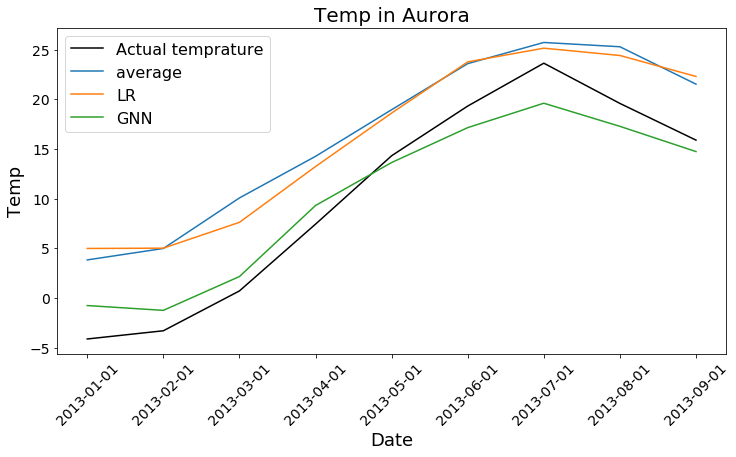

In [80]:

test_date = test_df['dt'].unique()
plot_temp_per_city(12, test_date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y)

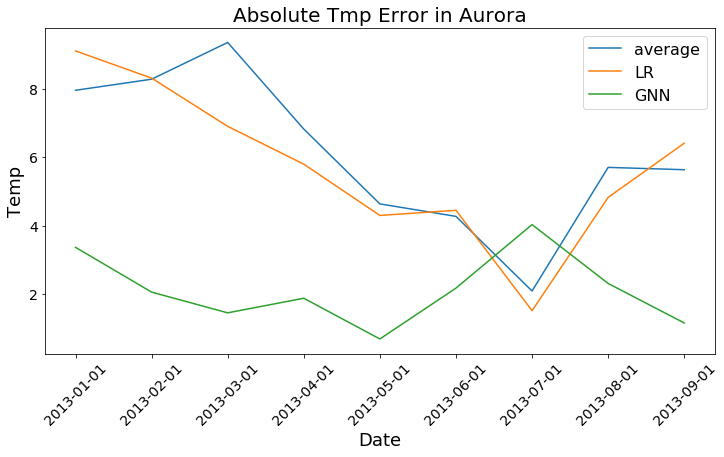

In [87]:
plot_error_temp_per_city(12, test_date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y)

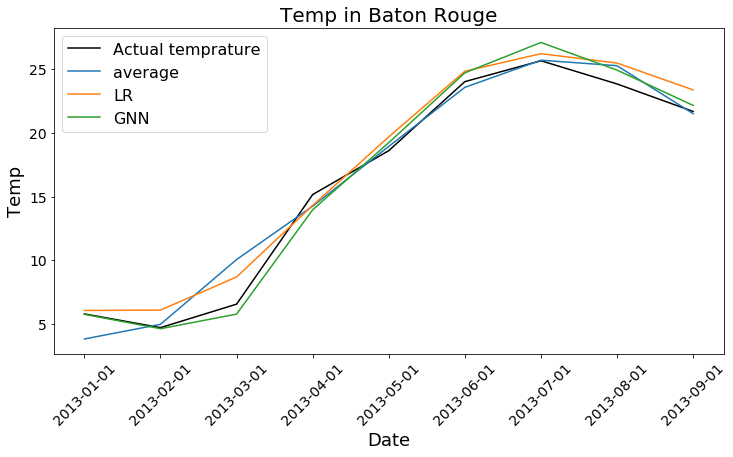

In [82]:
plot_temp_per_city(15, test_date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y)

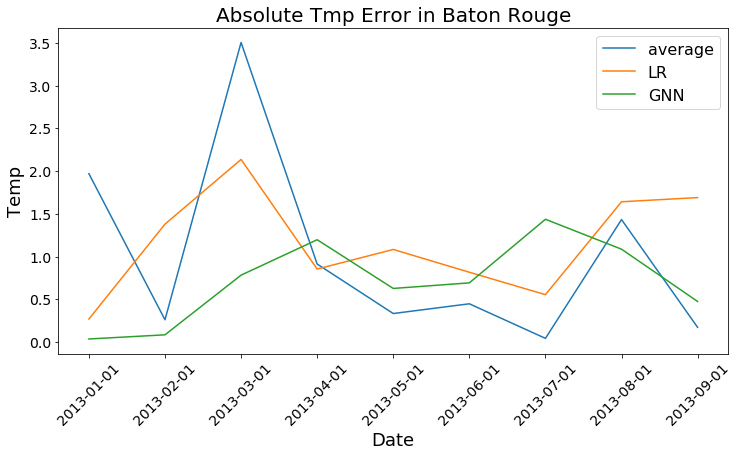

In [86]:
plot_error_temp_per_city(15, test_date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y)

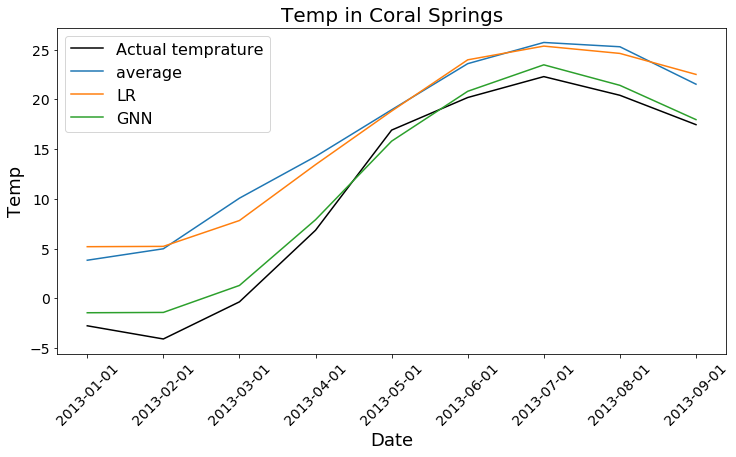

In [84]:
plot_temp_per_city(35, test_date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y)

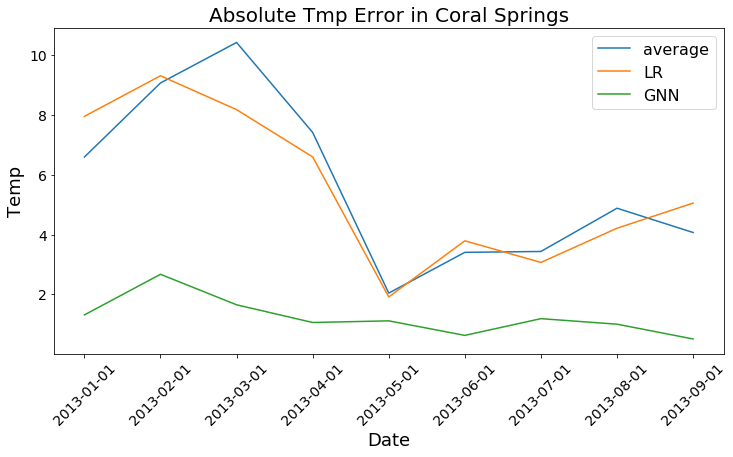

In [85]:
plot_error_temp_per_city(35, test_date, test_y, lr_pred_y, avg_pred_y, gnn_pred_y)